Big Data CS-GY 6513 Spring 2023 \\
Fighting Fake News and Identifying Trends \\
Abhishek Bansal (ab10192), Amrutha Patil (ap7982), Charmee Mehta (cm6389), Sejal Jagtap (sj3251)

This file is used for (1) importing data, (2) preprocessing, (3) data analysis and visualization, (4) preparing data for machine learning, (5) experimenting with different machine learning models

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [ ]:
from pyspark.sql.functions import *
import pyspark.ml.feature
from pyspark.ml.feature import Tokenizer,StopWordsRemover,CountVectorizer,IDF
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import StringType
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
from pyspark.sql import SparkSession
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the CSV file in Google Drive
file_path = '/content/drive/MyDrive/bigdataproject/filtered_news.csv'

df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+
|                  id|              domain|                type|                 url|             content|          scraped_at|         inserted_at|          updated_at|               title|             authors|meta_description|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+
|                   2|       express.co.uk|               rumor|https://www.expre...|Life is an illusi...|                null|                null|                null|                null|                null|            null|
|They finally have...|                null|                null|                null

In [ ]:
distinct_types = df.select("type").distinct()
distinct_types.show()

+--------------------+
|                type|
+--------------------+
| where the raid b...|
| so a payment of ...|
|  and it is urgent."|
| ultimately becom...|
| but the literal ...|
| actually have we...|
|               Melba|
|            fellas.”|
|     pure and simple|
| can only find pr...|
| was born in Gaza...|
| not liberal medi...|
|     Variety reports|
|” Clovis Police D...|
| is “a transgende...|
| I wondered if Go...|
| corrupt leaders ...|
| Ontario’s minimu...|
| it “buffers the ...|
| “we’ve exposed o...|
+--------------------+
only showing top 20 rows



In [ ]:
import matplotlib.pyplot as plt

from pyspark.sql.functions import trim

# Filter the DataFrame to include only rows where type = "fake" (with whitespace trimmed)
fake_df1 = df.filter(trim(df.type) == "fake")

In [ ]:
fake_df1.show()

+---+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+----------------+
| id|              domain|type|                 url|             content|          scraped_at|         inserted_at|          updated_at|               title|authors|meta_description|
+---+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+----------------+
| 34|   beforeitsnews.com|fake|http://beforeitsn...|Headline: Bitcoin...|                null|                null|                null|                null|   null|            null|
| 35|   beforeitsnews.com|fake|http://beforeitsn...|Water Cooler 1/25...|                null|                null|                null|                null|   null|            null|
| 36|   beforeitsnews.com|fake|http://beforeitsn...|Veteran Commentat...|            

In [ ]:

# # Count the number of occurrences for each type
# type_counts = fake_df1.groupBy("type").count().collect()

# # Extract the type labels and their corresponding counts
# labels = [row["type"] for row in type_counts]
# counts = [row["count"] for row in type_counts]

# # Create a pie chart
# plt.pie(counts, labels=labels, autopct="%1.1f%%")
# plt.title("Distribution of Types")
# plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle
# plt.show()


KeyboardInterrupt: ignored

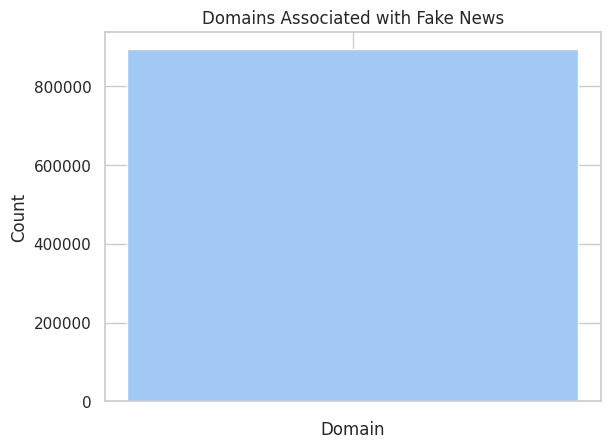

In [ ]:

from pyspark.sql.functions import split

# Extract the domain names from the URLs by splitting on "."
fake_domains = fake_df1.select(split("domain", ".").getItem(1).alias("domain")).na.drop()

# Group the DataFrame by the domain column and count the occurrences
domain_counts = fake_domains.groupBy("domain").count().collect()

# Extract the domains and their respective counts
domains = [row["domain"] for row in domain_counts]
counts = [row["count"] for row in domain_counts]

# Create a bar chart to visualize the domain counts
plt.bar(domains, counts)
plt.xlabel("Domain")
plt.ylabel("Count")
plt.title("Domains Associated with Fake News")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()


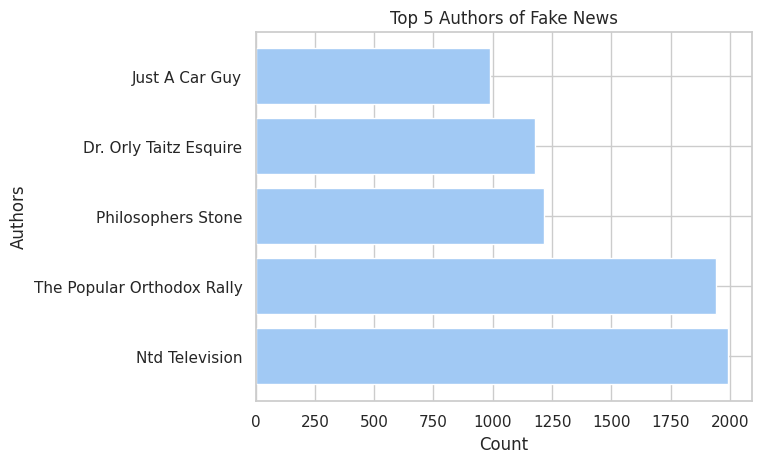

In [ ]:

# Group the DataFrame by the "authors" column and count the occurrences
author_counts = fake_df1.groupBy("authors").count()

# Sort the author counts in descending order
sorted_author_counts = author_counts.orderBy(desc("count"))

sorted_author_counts = sorted_author_counts.na.drop()

# Select the top 5 authors
top_5_authors = sorted_author_counts.limit(5).collect()

# Extract the author names and their respective counts
authors = [row["authors"] for row in top_5_authors]
counts = [row["count"] for row in top_5_authors]

plt.barh(authors, counts)  # Use barh for horizontal bar chart
plt.xlabel("Count")
plt.ylabel("Authors")
plt.title("Top 5 Authors of Fake News")
plt.show()


In [ ]:
df = df_all.select('content','type')
df = df.na.drop()
df = df.filter(col("type").isin(["fake", "satire", "bias", "conspiracy", "junksci", "clickbait", "political", "hate", "rumor", "reliable", "unreliable"]))
# df.show()

Life is an illusion, at least on a quantum level, in a theory which has recently been confirmed by a set of researchers.


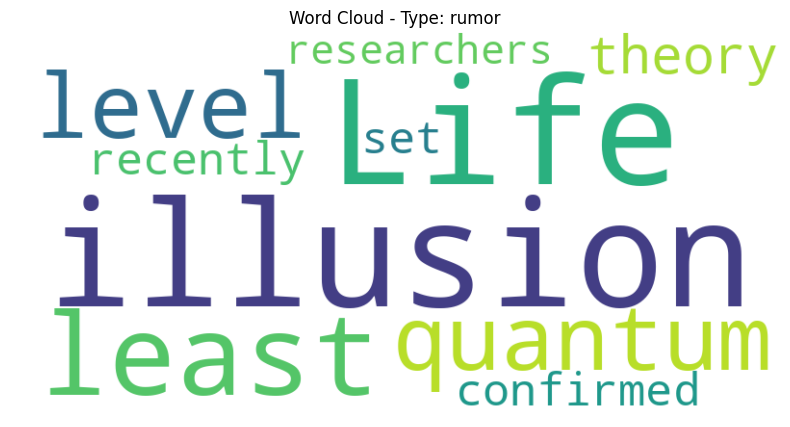

Unfortunately, he hasn’t yet attacked her for Islamic terrorism-connections, but we know he will. Below are several links that explain in detail why having Huma Abedin anywhere near the White House would be like inviting in the terrorism-linked Muslim Brotherhood, which has been banned in Egypt and the UAE. BNI Readers, please forward the damning […] The Los Angeles Police Department has been denied $3 million in federal aid for law enforcement. While there is no official announcement as to why, it is more than likely that it has everything to do with LA’s “sanctuary city” status for harboring illegal aliens. Donald Trump and Attorney General Jeff Sessions have repeatedly said […] The White House has decided to quietly withdraw from all its ties with the Ramallah-based Palestinian Authority and Mahmoud Abbas. “The time has come to cut off the tongues of those who support peace and those who mourn it.” (Can’t disagree there, Arab Muslims occupying Israel will never live in peace with th

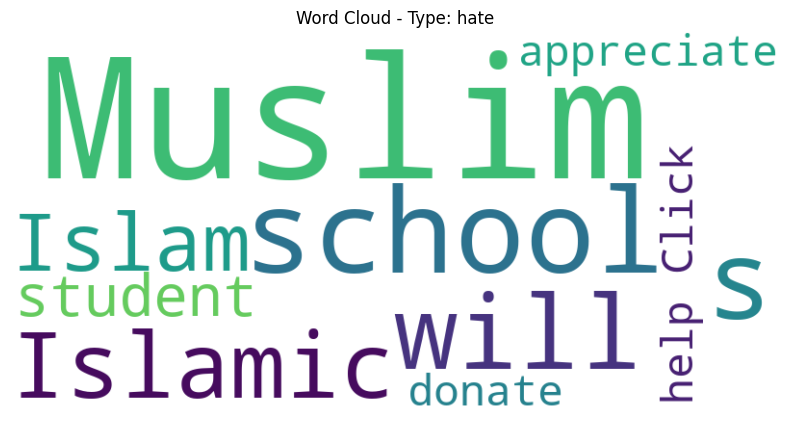

UN-Backed Police Massacred Haitians With Impunity It should have come as no surprise that the same “rebels” the US supported in its 2011 war against Libya are now selling Blacks into slavery at auction, said Robin Philpot, who pub “When the police finally left the campus, around 11 a.m., nine civilians lay dead in the courtyard — five of whom had been shot in the head.” Zambia Must Clarify Whether It Will Host Israel-Africa Summit Most people’s pets are a member of the family and, as is the case with dogs and cats, they love their owners unconditionally. Other types of pets may not be quite so affectionate or even terribly aware of their owners, which makes what this lizard did so shocking. Who knew that lizards could actually communicate with humans? Texas resident Aaron Roman shared the amazing video of his reptile’s reaction to Aaron’s wave, which he caught on video. It appears that the lizard, named Evan, is waving back! Dogs are fantastic. They provide so much joy in our lives. If

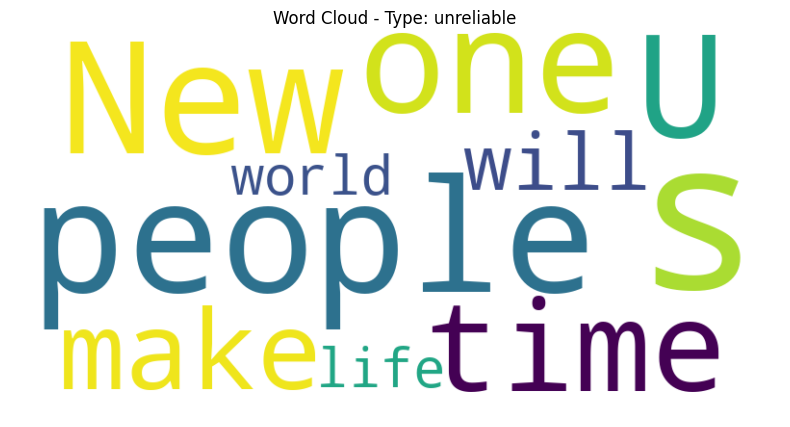

"""…I have set before you life and death "Why We Oppose Planned Parent Hood ( The following is a reprint of the STOPP's essay ""Why We Oppose Planned Parenthood"") Planned Parenthood is not a benevolent organization trying to strengthen women's rights. It is a cold If You Love The Children "Follow the below steps to view photos In one of the seven albums: Subscribe to Canada Free Press for FREE We have all heard it for years, marijuana is a gateway to other drugs. But, the question is, is that really the case? “Marijuana is a gateway drug,” t… If you or a loved one suffers from vertigo, you know how difficult it can be to get around it. Thankfully, you can use these natural remedies to allev… Depression can appear out of nowhere and when it does, it can be hard to get it to go away. However, you don’t need an antidepressant prescription to … "California Here We Come! Subscribe to Canada Free Press for FREE While most of us only want to do what is best for our children some of us have a

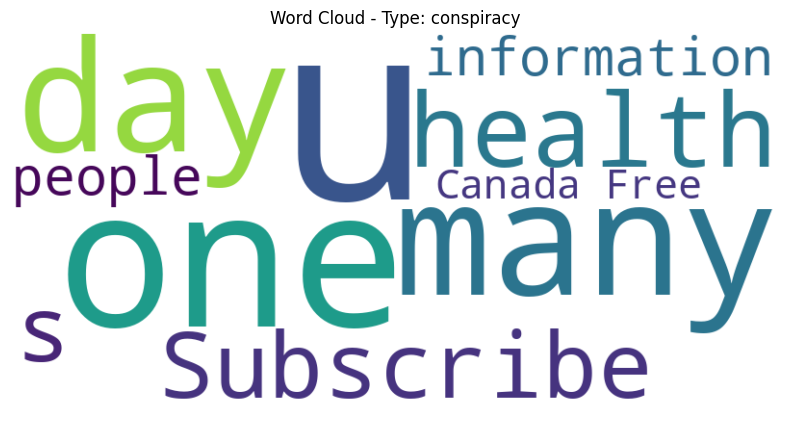

The website from which you got to this page is protected by Cloudflare. Email addresses on that page have been hidden in order to keep them from being accessed by malicious bots. You must enable Javascript in your browser in order to decode the e-mail address. Sarah Huckabee Sanders is a well-paid liar. Day after day, she takes to the White House Press Briefing Room to defend whatever ridiculous thing Trump has done most recently. She’s achieved infamy through her brazen willingness to state literally any absurdity with a straight face. Brian Neale is the Center for Medicare & Medicaid Services (CMS) Deputy Administrator, and the Director for the Center for Medicaid and CHIP Services. Neale is an ally of Vice President Mike Pence and was appointed to his role in the Medicaid program in March. He was the healthcare policy director under Pence back when Pence was the governor of Indiana (their relationship goes back even further than that), and he helped design Indiana’s Medicaid expansi

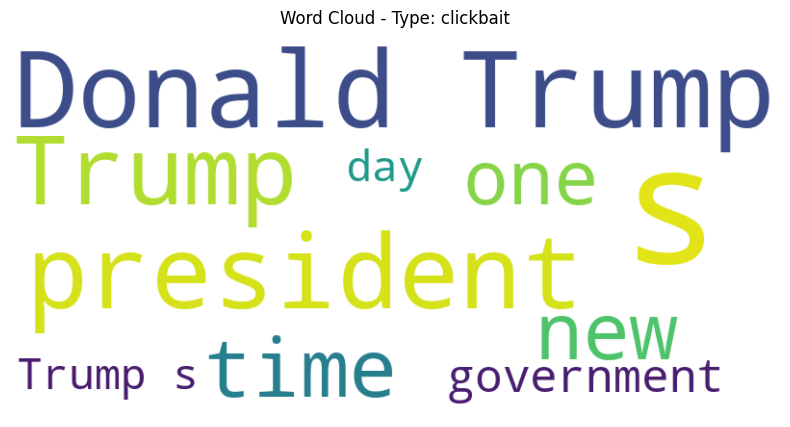

For as long as he can remember, Malcolm Turnbull has wanted to be an inconsequential, powerless leader at the beck and call of a small... For as long as he can remember, Malcolm Turnbull has wanted to be an inconsequential, powerless leader at the beck and call of a small... Senators from the Australian Greens will be stamped with their country of origin from next week, to help them remember where they come from. Have you ever stopped and wondered what it would be like if I had to live without my phone for a week? Nah, me neither.... If you don’t believe in fate, here’s a story that’s sure to change your mind. The High Court has decided to let Nationals senator Matt Canavan off this time, after he was able to produce a letter from his Mum... Americans were stunned to discover that their Government had shutdown this weekend, having been totally unaware that it had even been functioning in the first place. Donald Trump marked his first year in office this weekend, saying it was the longe

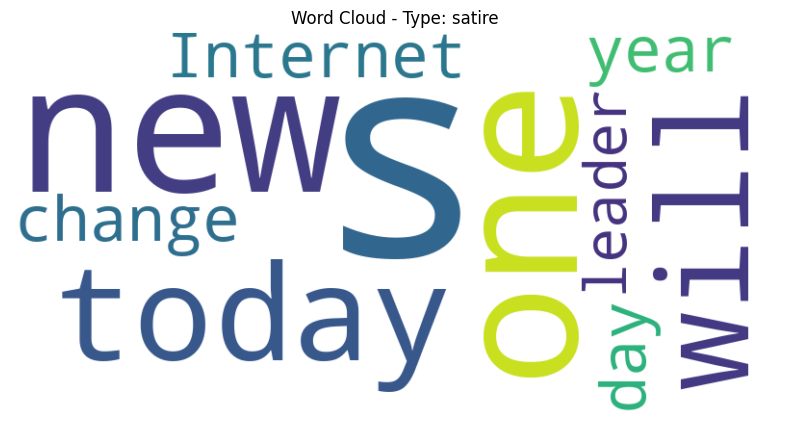

Headline: Bitcoin & Blockchain Searches Exceed Trump! Blockchain Stocks Are Next! Water Cooler 1/25/18 Open Thread; Fake News ? CNN Still Won’t Correct Fake Story; Feminists Demand Feminist Science; Grumpy Cat Goes To Court Veteran Commentator Calls Out the Growing “Ethnonationalism” at Fox News (and It’s SO Ugly) Lost Words, Hidden Words, Otters, Banks and Books Red Alert: Bond Yields Are SCREAMING “Inflation is coming!” Scientists move Doomsday Clock ahead by 30 seconds, closest to apocalypse since 1953 – “As of today, it is two minutes to midnight” Why Sandwiches Must Be Banned Poll: Calls for War From Israelis and Palestinians SKYROCKET Due to Trump’s Jerusalem Deceleration Every college basketball fan knows all too well how prevalent upsets can be during any given week of this cantankerous and infinitely enjoyable sport. But this week…it was a rough time for any program that had a number next to the name of their respective academic institutions. Not only did four of the top 10 te

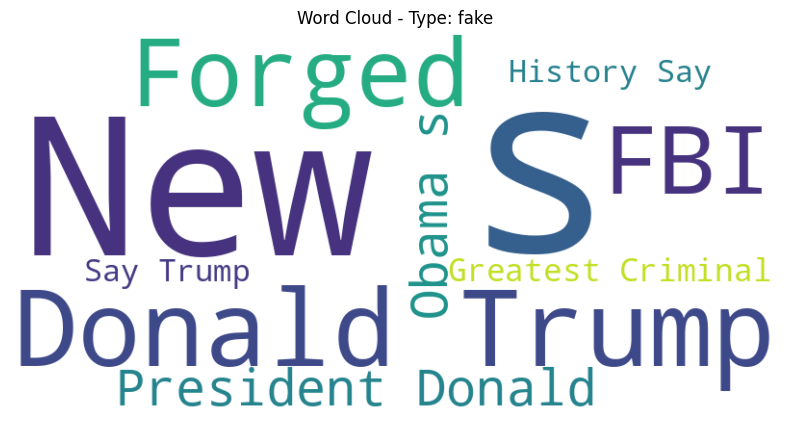

"Facebook/DestinyTheGame Promo image for ""Destiny 2's"" first DLC ""Curse of Osiris."" "(Screenshot: Facebook) Dr. Melina Abdullah, professor and chair of Pan-African studies at California State University gets ready to summon the spiritual energy of victims of officer involved shootings at the Hollywood United Methodist Church in Hollywood , California, on Thursday January 11, 2018. "(Photo: Reuters) The teams of North and South Korea march into the stadium during the opening ceremony at the Torino 2006 Winter Olympic Games in Turin, Italy. "(Photo: Reuters/Dado Ruvic) Facebook. "(Screencap: YouTube/Tidningen Dagen) Annahita Parsan (L), minister in the Church of Sweden, in a video posted on April 28, 2017. "(Screenshot: YouTube / MJofLakeland1) A Metro bus crosses an intersection out front of the Paul S. Sarbanes Transit Center in Silver Spring, Maryland in a video posted to YouTube on Apr 10, 2016. "(Screenshot:Chick-fil-A) A Chick-fil-A restaurant proudly displays the companies ""c

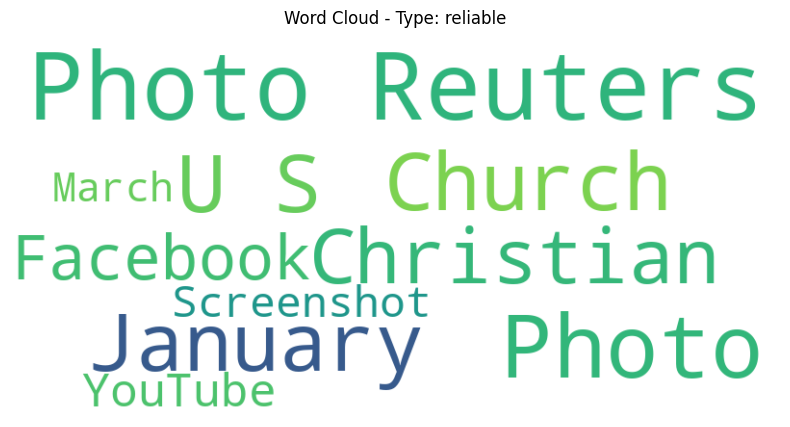

Lila Rose, president of the pro-life group Live Action, says President Trump is off to a “promising” start on pro-life issues, but she says the president and Congress must do what it takes to defund Planned Parenthood at a time when Democrats are voting in favor of “infanticide.” The mobile shortcut will then be added as an icon on your home screen. Two black leaders who were prevented from demonstrating outside the Smithsonian African-American history museum against a decades-long “genocide” carried out against black children through abortion resolved a free-speech case against the federal government in their favor. The website from which you got to this page is protected by Cloudflare. Email addresses on that page have been hidden in order to keep them from being accessed by malicious bots. You must enable Javascript in your browser in order to decode the e-mail address. A federal court has issued a decision to dismiss a lawsuit brought by the NAACP and the ACLU against an Arizona bi

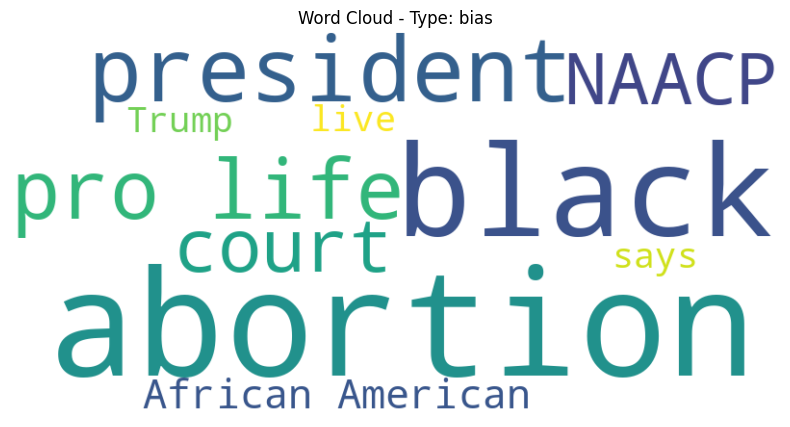

It is rather hard to write with eclipse glasses on this morning, but “I want to be ready,” as the old spiritual intones. Not ever known for culinary process, I even tried to turn Oreos into eclipse cookies. Massive fail! As our nation celebrated Labor Day, giving attention to the role and dignity of workers, we should also consider the role of human agency in accomplishing divine labor. Theologians always interrogate such things! Surely the work of Christians is more than simply fueling the engine of capitalism; meaningful work also participates in God’s intention for the world. Yet, determining how God is at work in this world is one of the hardest theological challenges. We hear quite a bit about survivors’ guilt these days. A neighbor’s house has a tree through the roof, while yours was spared. A soldier walks behind another; the one in the lead steps on a landmine, and the follower does not suffer loss of limbs. The hurricane skirts your hometown, and the adjoining county is hard h

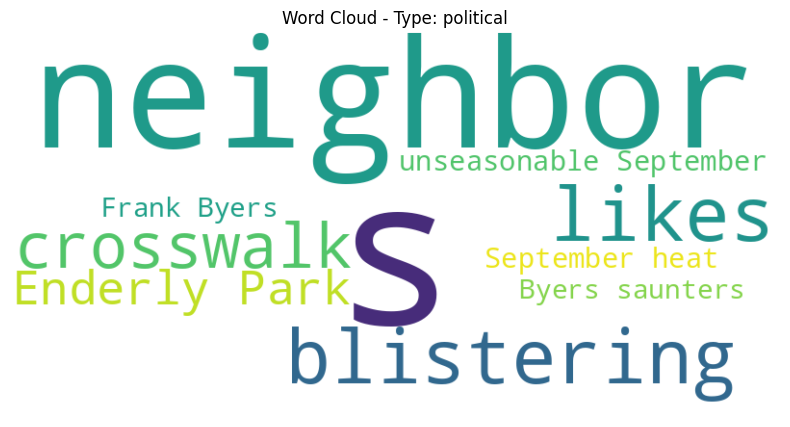

Decades ago, when an individual claimed to work at a military facility that required top level security clearance and spoke about classified military secrets and technology, they were ridiculed. This is why, in some cases, they were allowed to speak and share sensitive information, because most of it was so unbelievable and easy to ridicule that, instead of the world of secrecy retaliating, they let these individuals speak their mind. Hey, you’re here, you made it! Congratulations on making it this far. I’m assuming the majority of people who saw this post only read the headline and then formed an opinion. It’s okay of course, everyone is entitled to their own opinion, but I’m here to offer you another perspective on this story. Building your network is key to a meaningful and aligned career. Whether you’re looking to build a private yoga practice, spread your inspiring message of change to others around the world, or have an amazing conscious business idea, you need a great close comm

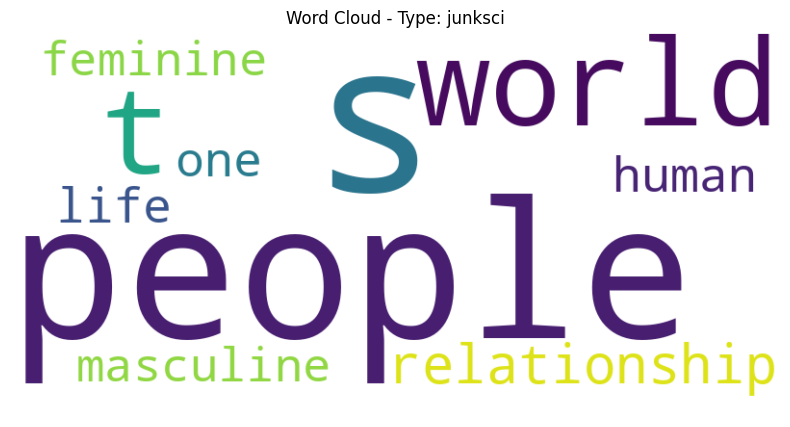

In [ ]:


import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql.functions import trim

# Get the distinct types from the DataFrame
distinct_types = [row['type'] for row in df.select(df['type'].alias('type')).distinct().collect()]

# Iterate over each type and create a word cloud
for type_ in distinct_types:
    # Get the content for the current type
    content = df.filter(df['type'] == type_).select('content').rdd.flatMap(lambda x: x).collect()

    # Concatenate all the content strings
    text = ' '.join(content)

    # Skip empty content
    if not text.strip():
        continue

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, max_words=10, background_color='white').generate(text)

    print(text)
    print(wordcloud)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - Type: {type_}')
    plt.axis('off')
    plt.show()



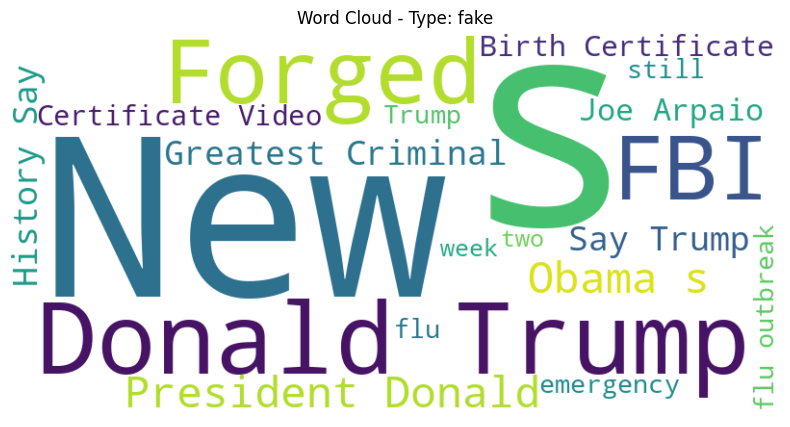

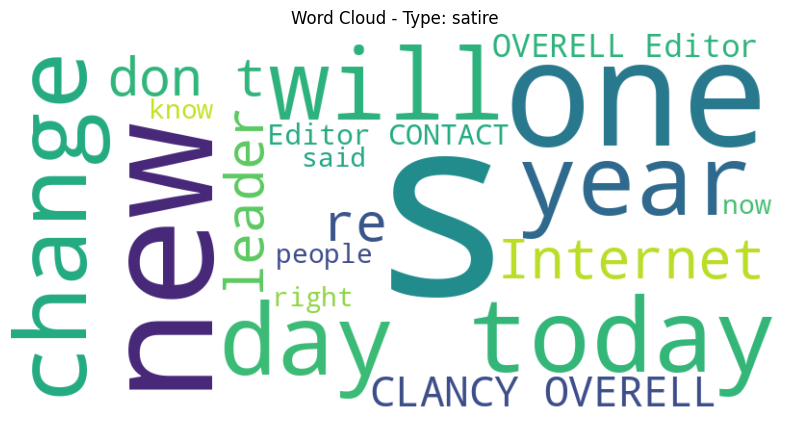

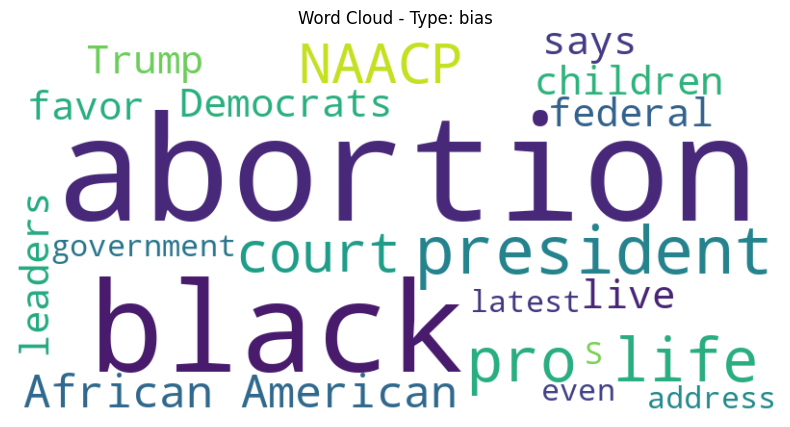

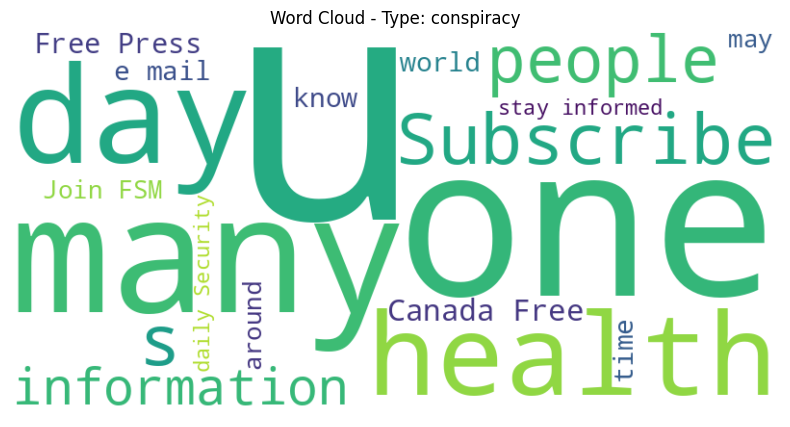

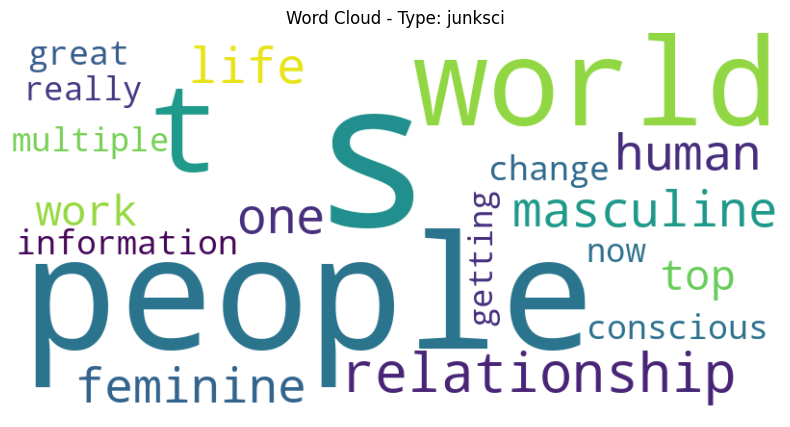

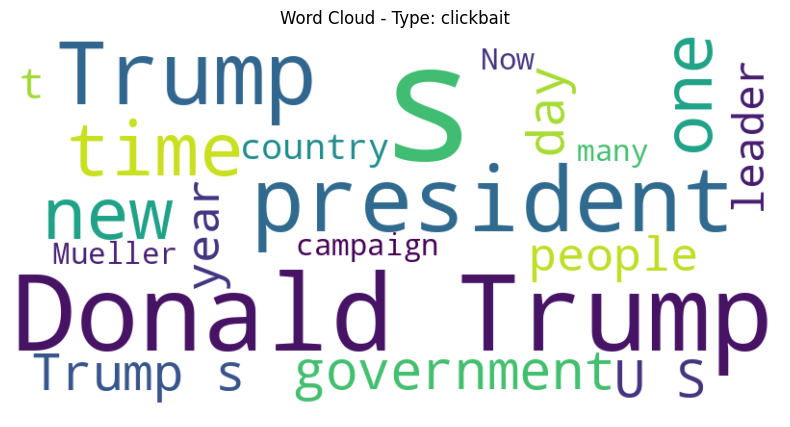

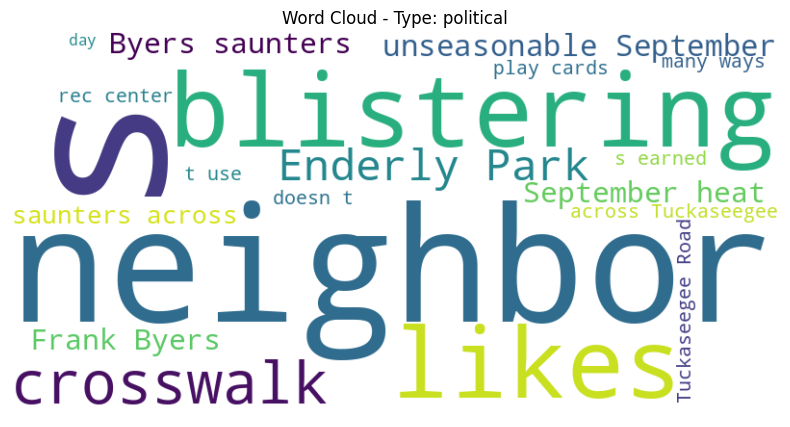

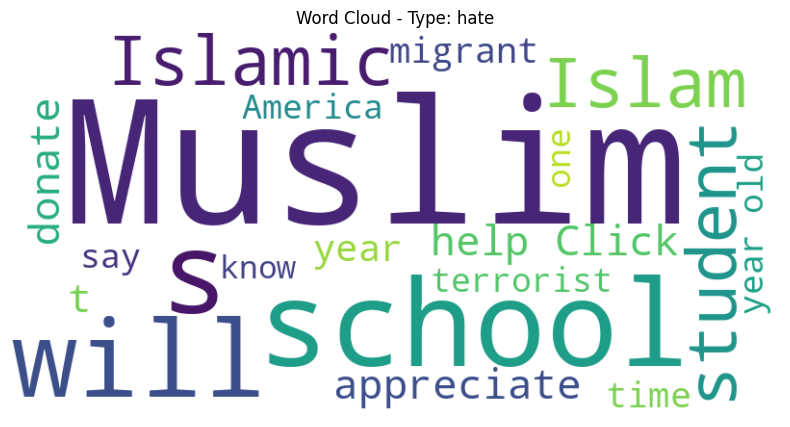

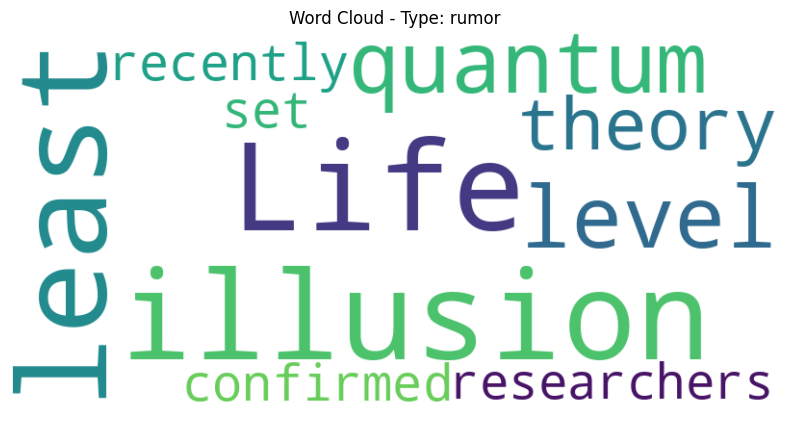

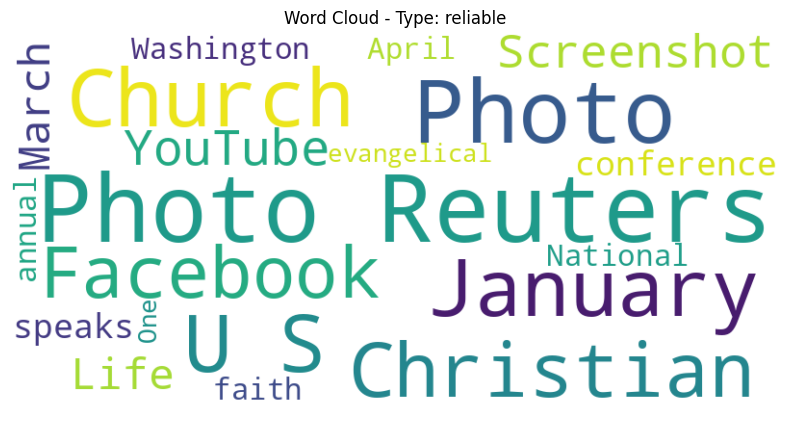

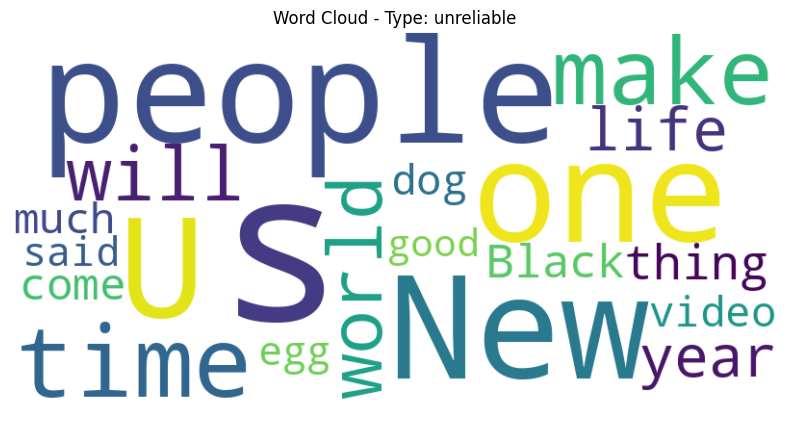

In [ ]:


import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql.functions import trim

# Get the distinct types from the DataFrame
distinct_types = ["fake", "satire", "bias", "conspiracy", "junksci", "clickbait", "political", "hate", "rumor", "reliable", "unreliable"]

# Iterate over each type and create a word cloud
for type_ in distinct_types:
    # Get the content for the current type
    content = df.filter(df['type'] == type_).select('content').rdd.flatMap(lambda x: x).collect()

    # Concatenate all the content strings
    text = ' '.join(content)

    # Skip empty content
    if not text.strip():
        continue

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, max_words=20, background_color='white').generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - Type: {type_}')
    plt.axis('off')
    plt.show()



In [ ]:
df.show()

+--------------------+----------+
|             content|      type|
+--------------------+----------+
|Life is an illusi...|     rumor|
|Unfortunately, he...|      hate|
|The Los Angeles P...|      hate|
|The White House h...|      hate|
|“The time has com...|      hate|
|The Central Ameri...|      hate|
|UN-Backed Police ...|unreliable|
|It should have co...|unreliable|
|“When the police ...|unreliable|
|Zambia Must Clari...|unreliable|
|"""…I have set be...|conspiracy|
|"Why We Oppose Pl...|conspiracy|
|The website from ...| clickbait|
|For as long as he...|    satire|
|For as long as he...|    satire|
|Most people’s pet...|unreliable|
|Dogs are fantasti...|unreliable|
|The lion may be k...|unreliable|
|Stories of animal...|unreliable|
|Sarah Huckabee Sa...| clickbait|
+--------------------+----------+
only showing top 20 rows



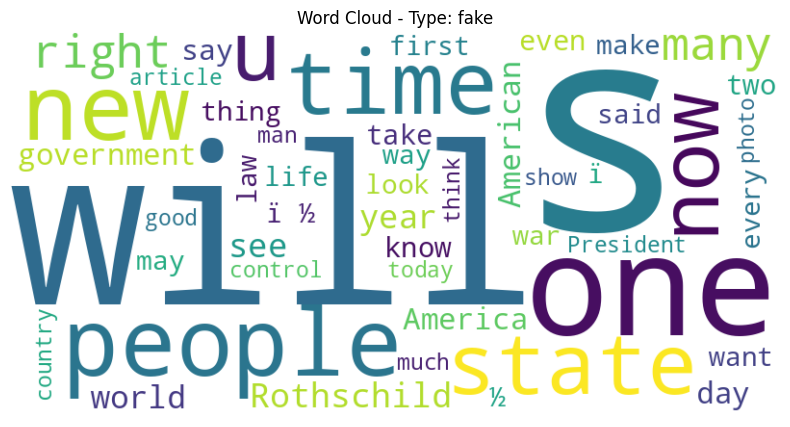

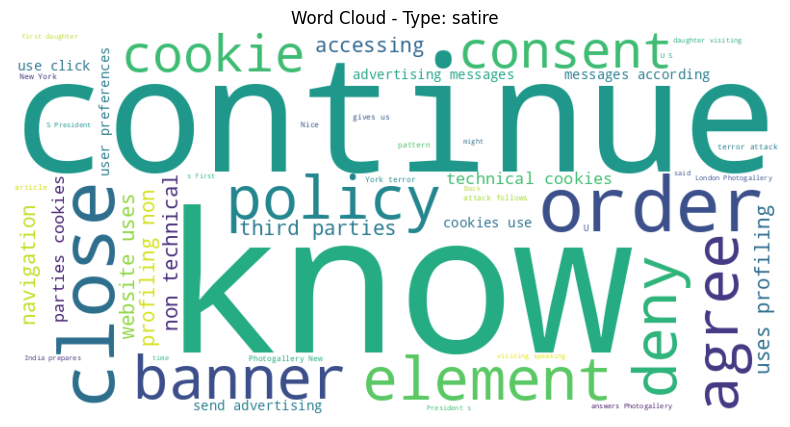

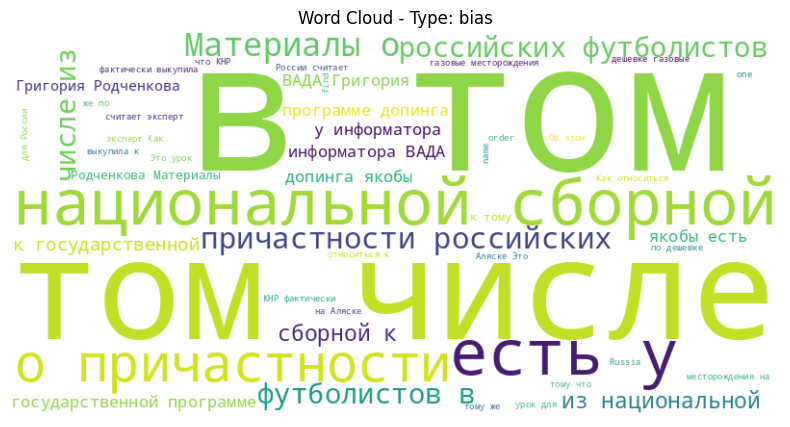

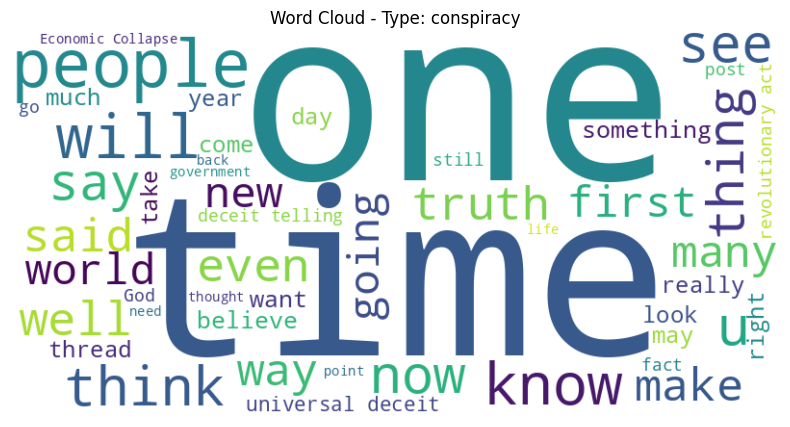

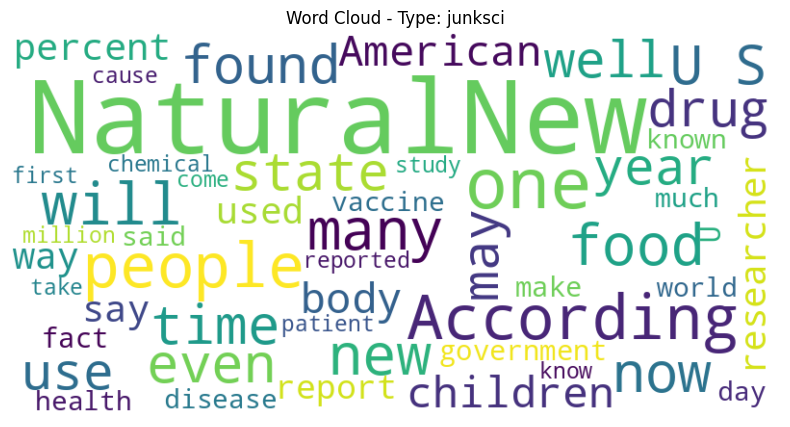

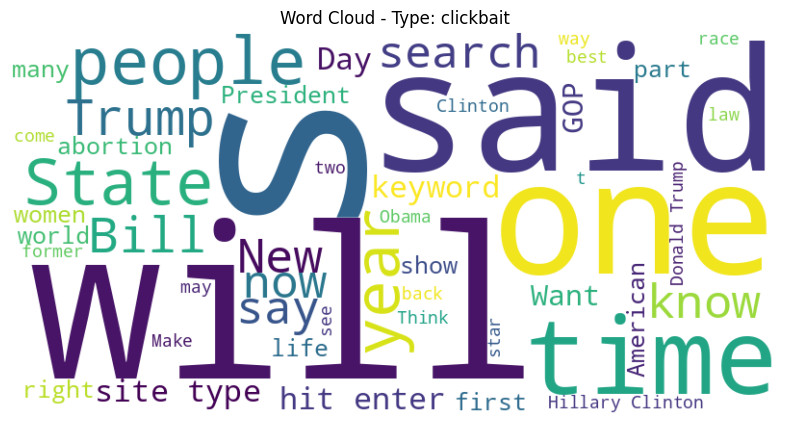

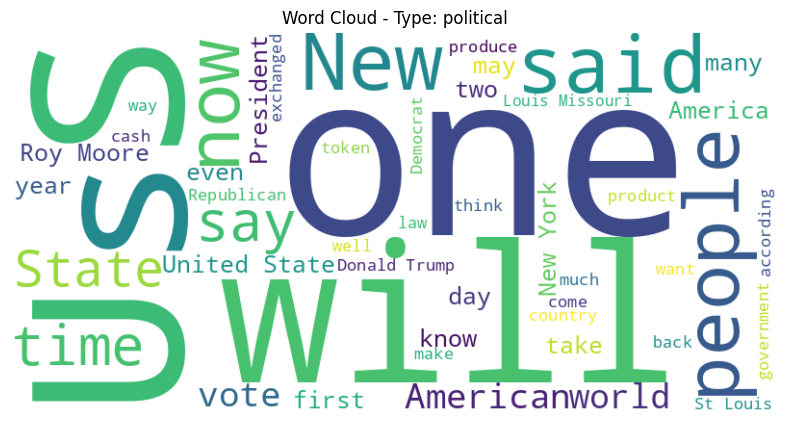

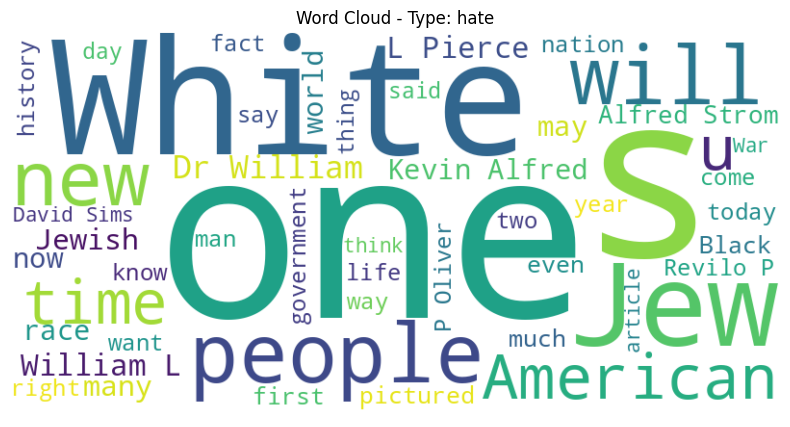

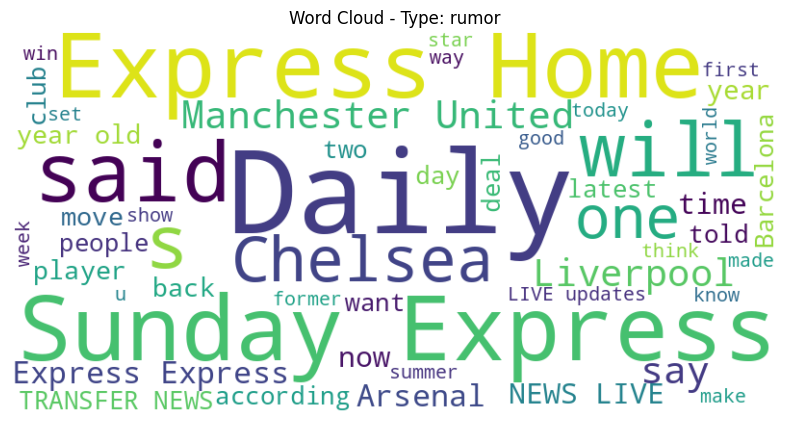

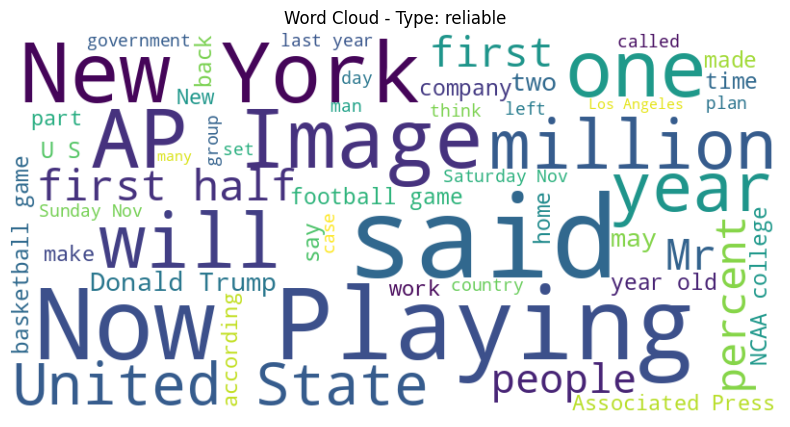

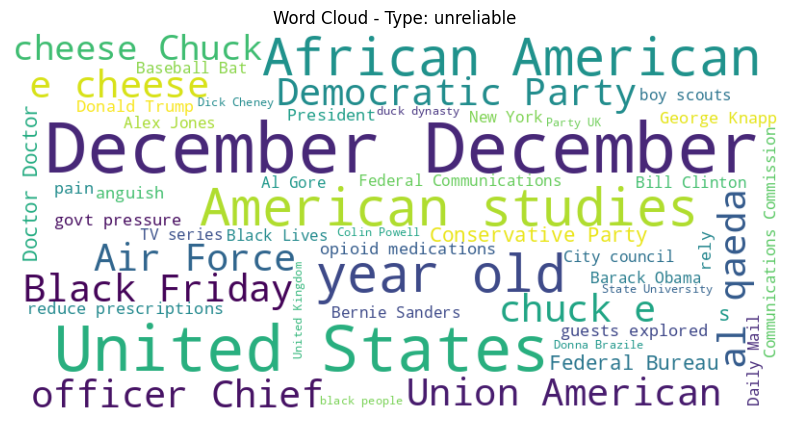

In [ ]:


import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql.functions import trim

# Get the distinct types from the DataFrame
distinct_types = ["fake", "satire", "bias", "conspiracy", "junksci", "clickbait", "political", "hate", "rumor", "reliable", "unreliable"]

# Iterate over each type and create a word cloud
for type_ in distinct_types:
    # Get the content for the current type
    content = df.filter(df['type'] == type_).select('content').rdd.flatMap(lambda x: x).collect()

    # Concatenate all the content strings
    text = ' '.join(content)

    # Skip empty content
    if not text.strip():
        continue

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white').generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - Type: {type_}')
    plt.axis('off')
    plt.show()



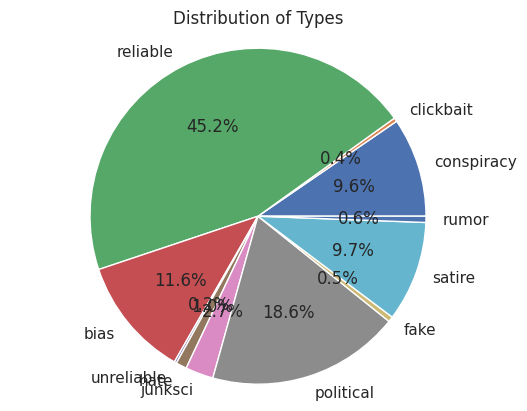

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of occurrences for each type
type_counts = df.groupBy("type").count().collect()

# Extract the type labels and their corresponding counts
labels = [row["type"] for row in type_counts]
counts = [row["count"] for row in type_counts]

# Set Seaborn style
sns.set(style="whitegrid")

# Create a pie chart
plt.pie(counts, labels=labels, autopct="%1.1f%%")
plt.title("Distribution of Types")

# Add Seaborn styling
sns.despine()  # Remove the top and right spines
sns.set_palette("pastel")  # Set a pastel color palette

plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [ ]:
df.count()

7741514

In [ ]:
tokenizer = Tokenizer(inputCol='content',outputCol='mytokens')
stopwords_remover = StopWordsRemover(inputCol='mytokens',outputCol='filtered_tokens')
vectorizer = CountVectorizer(inputCol='filtered_tokens',outputCol='rawFeatures')
idf = IDF(inputCol='rawFeatures',outputCol='vectorizedFeatures')

In [ ]:
labelEncoder = StringIndexer(inputCol='type',outputCol='label').fit(df)
labelEncoder.transform(df).show(1000)

+--------------------+----------+-----+
|             content|      type|label|
+--------------------+----------+-----+
|Life is an illusi...|     rumor| 10.0|
|Unfortunately, he...|      hate|  5.0|
|The Los Angeles P...|      hate|  5.0|
|The White House h...|      hate|  5.0|
|“The time has com...|      hate|  5.0|
|The Central Ameri...|      hate|  5.0|
|UN-Backed Police ...|unreliable|  0.0|
|It should have co...|unreliable|  0.0|
|“When the police ...|unreliable|  0.0|
|Zambia Must Clari...|unreliable|  0.0|
|"""…I have set be...|conspiracy|  1.0|
|"Why We Oppose Pl...|conspiracy|  1.0|
|The website from ...| clickbait|  2.0|
|For as long as he...|    satire|  3.0|
|For as long as he...|    satire|  3.0|
|Most people’s pet...|unreliable|  0.0|
|Dogs are fantasti...|unreliable|  0.0|
|The lion may be k...|unreliable|  0.0|
|Stories of animal...|unreliable|  0.0|
|Sarah Huckabee Sa...| clickbait|  2.0|
|Brian Neale is th...| clickbait|  2.0|
|Egypt’s president...| clickbait|  2.0|


In [ ]:
label_dict = {'reliable':0.0,'political':1.0,'bias':2.0,'fake':3.0,'conspiracy':4.0,
 'rumor':5.0, 'unreliable':6.0,'clickbait':7.0,'junksci':8.0, 'satire':9.0, 'hate':10.0}
#  note: label_dict might change with every run

In [ ]:
df = labelEncoder.transform(df)

In [ ]:
(trainDF,testDF) = df.randomSplit((0.7,0.3),seed=42)

In [ ]:
# logistic regression
lr = LogisticRegression(featuresCol='vectorizedFeatures',labelCol='label')

# # logistic regression
# lr = LogisticRegression(featuresCol='vectorizedFeatures',labelCol='label')
# 0.45

# svm
# lr = LinearSVC(featuresCol='vectorizedFeatures', labelCol='label')
# 0.40

# Create a Decision Tree model
# dt = DecisionTreeClassifier(featuresCol='vectorizedFeatures', labelCol='label')
# 0.45

# Create a Random Forest model
# rf = RandomForestClassifier(featuresCol='vectorizedFeatures', labelCol='label')
# 0.67

# Create a Gradient-Boosted Trees model
# gbt = GBTClassifier(featuresCol='vectorizedFeatures', labelCol='label')



In [ ]:
pipeline = Pipeline(stages=[tokenizer,stopwords_remover,vectorizer,idf,lr])

In [ ]:
lr_model = pipeline.fit(trainDF)

In [ ]:
predictions = lr_model.transform(testDF)
predictions.show()

+--------------------+----------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|             content|      type|label|            mytokens|     filtered_tokens|         rawFeatures|  vectorizedFeatures|       rawPrediction|         probability|prediction|
+--------------------+----------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|"""…I have set be...|conspiracy|  1.0|["""…i, have, set...|["""…i, set, life...|(6722,[26,347,634...|(6722,[26,347,634...|[0.71158673297336...|[0.10214323737001...|       8.0|
|"(Photo: Baltimor...|  reliable|  7.0|["(photo:, baltim...|["(photo:, baltim...|(6722,[83,141,923...|(6722,[83,141,923...|[3.04371814617481...|[0.16229831019481...|       7.0|
|"(Photo: Facebook...|  reliable|  7.0|["(photo:, facebo...|["(photo:, facebo...|(6722,[83,849,214...|(6722,[83,849

In [ ]:
predictions.select('rawPrediction','probability','type','label','prediction').show()

+--------------------+--------------------+----------+-----+----------+
|       rawPrediction|         probability|      type|label|prediction|
+--------------------+--------------------+----------+-----+----------+
|[0.71158673297336...|[0.10214323737001...|conspiracy|  1.0|       8.0|
|[3.04371814617481...|[0.16229831019481...|  reliable|  7.0|       7.0|
|[-0.3406697227052...|[4.55361018910108...|  reliable|  7.0|       7.0|
|[0.12282615105162...|[0.03747325730227...|  reliable|  7.0|       7.0|
|[-0.7594084526381...|[0.00321606733524...|  reliable|  7.0|       7.0|
|[1.02447302166093...|[0.14876732535468...|  reliable|  7.0|       7.0|
|[-0.1474879722238...|[0.03278171716583...|  reliable|  7.0|       7.0|
|[0.87954034074295...|[0.14843237071267...|  reliable|  7.0|       1.0|
|[0.66163840128688...|[0.09439466041369...|  reliable|  7.0|       7.0|
|[-3.7741359987395...|[2.09263348744135...|  reliable|  7.0|       1.0|
|[-0.8686993464036...|[4.34200879612943...|  reliable|  7.0|    

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')

In [ ]:
accuracy = evaluator.evaluate(predictions)
accuracy

0.45495495495495497